In [1]:
import sys
sys.path.append("../../") # gruppe_3 als lib dir

# ----------------------------------------------------------------------------------------
# VORSICHT: Änderungen an gruppe_3 - Files erfordern womöglich einen Jupyter-Neustart
# ----------------------------------------------------------------------------------------

import os

from gruppe_3.dataset import DatasetReader, InputMode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ----------------------------------------------------------------------------------------
# werden die Parameter nach dem InputMode weggelassen, so werden alle Dateien im Ziel-
# verzeichnis gelesen. Letzteres wird durch eine Umgebungsvariable adressiert, damit
# alle entspannt ins Git pushen können.
# ----------------------------------------------------------------------------------------

dataset_reader = DatasetReader(
    os.environ.get('EXTRA_SENSORY_DATASET'),
    InputMode.users
)

X, y = dataset_reader.read()
cat_features = [X.columns.get_loc(f) for f in dataset_reader.discrete_group_names]


D:\Development\Projects\mustererkennung\data\00EABED2-271D-49D8-B599-1D4A09240601.features_labels.csv
D:\Development\Projects\mustererkennung\data\098A72A5-E3E5-4F54-A152-BBDA0DF7B694.features_labels.csv
D:\Development\Projects\mustererkennung\data\0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv
D:\Development\Projects\mustererkennung\data\0BFC35E2-4817-4865-BFA7-764742302A2D.features_labels.csv
D:\Development\Projects\mustererkennung\data\0E6184E1-90C0-48EE-B25A-F1ECB7B9714E.features_labels.csv
D:\Development\Projects\mustererkennung\data\1155FF54-63D3-4AB2-9863-8385D0BD0A13.features_labels.csv
D:\Development\Projects\mustererkennung\data\11B5EC4D-4133-4289-B475-4E737182A406.features_labels.csv
D:\Development\Projects\mustererkennung\data\136562B6-95B2-483D-88DC-065F28409FD2.features_labels.csv
D:\Development\Projects\mustererkennung\data\1538C99F-BA1E-4EFB-A949-6C7C47701B20.features_labels.csv
D:\Development\Projects\mustererkennung\data\1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842.

In [3]:
pl = ['label:IN_CLASS', 'label:OR_outside', 'label:BATHING_-_SHOWER', 'label:DOING_LAUNDRY', 'label:AT_A_BAR', 'label:AT_THE_GYM']
def mod_row(yp):
    for s in pl:
        if yp[s] == 1.0:
            return 0.0
    return 1.0
y = y[pl].fillna(0)
y['label:VARIOUS_A_NONE']=y.apply(mod_row, axis=1)
y['label:VARIOUS'] = y[pl].idxmax(axis=1)
y = y['label:VARIOUS']
le = LabelEncoder()
y=le.fit_transform(y)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)


In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from catboost import Pool

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool

clf = Pipeline([
    ("a", SimpleImputer()),
    ("b", StandardScaler()),
    ("classify", CatBoostClassifier(
        verbose=10,
        task_type="GPU",
        iterations=10000,
        early_stopping_rounds=200,
        l2_leaf_reg=3.0,
        loss_function = "MultiClass",
        depth = 6
    ))
])

y_pred = clf.fit(X_train,y_train,{
    "classify_cat_features": cat_features,
    "classify_eval_set": Pool(X_val, y_val, cat_features=cat_features),
    "classify_verbose_eval": 100
}).predict(X_test)
accuracy_score(y_test,y_pred)


0:	learn: -1.6583073	test: -1.6694730	best: -1.6694730 (0)	total: 67.6ms	remaining: 11m 16s
200:	learn: -0.1394009	test: -0.2328058	best: -0.2328058 (200)	total: 13.5s	remaining: 10m 56s
400:	learn: -0.1112985	test: -0.2197863	best: -0.2193956 (393)	total: 26.3s	remaining: 10m 29s
600:	learn: -0.0965790	test: -0.2198965	best: -0.2190636 (572)	total: 38.6s	remaining: 10m 3s
800:	learn: -0.0870391	test: -0.2159977	best: -0.2156739 (798)	total: 50.9s	remaining: 9m 44s
1000:	learn: -0.0801054	test: -0.2123598	best: -0.2122940 (994)	total: 1m 3s	remaining: 9m 27s
1200:	learn: -0.0747486	test: -0.2066126	best: -0.2063791 (1191)	total: 1m 15s	remaining: 9m 11s
1400:	learn: -0.0700431	test: -0.2072455	best: -0.2059380 (1240)	total: 1m 27s	remaining: 8m 57s
bestTest = -0.2059380357
bestIteration = 1240
Shrink model to first 1241 iterations.


0.9724787661158887

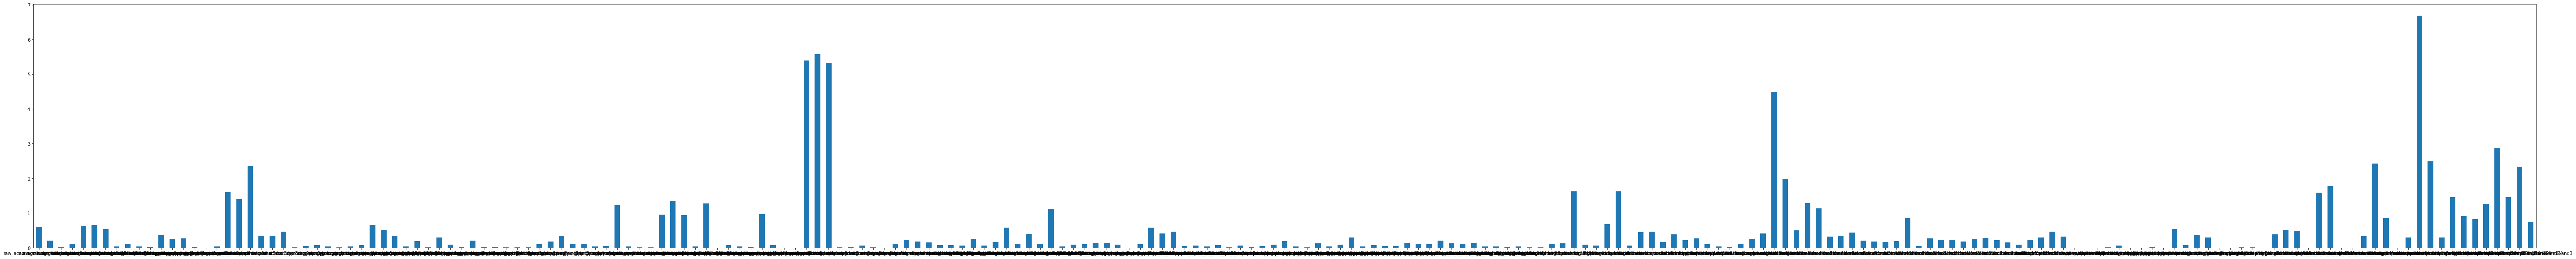

In [8]:
from catboost import Pool
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [100, 10]

cat_boost = clf.named_steps['classify']
importance=pd.Series(cat_boost.classifier.get_feature_importance(Pool(X_test, label=y_test)),index=X_test.columns,name="importance")
importance.plot.bar(y='importance',rot=0)
